This notebook introduces the notion of computing the general linear model using linear algebra.  First we load the necessarily libraries.

In [1]:
import numpy,pandas
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
import statsmodels
from statsmodels.formula.api import ols,glsar
from statsmodels.tsa.arima_process import arma_generate_sample
from scipy.linalg import toeplitz
from IPython.display import display, HTML

%matplotlib inline

### A simple example

We start with a simple example of an independent samples t-test. First, let's make a function that will generate some data. We will assume that there are two conditions with specified means and standard deviations

In [2]:
def make_ttest_data(n_obs=[50,50],mean_obs=[10,10.1],sd_obs=[2,2]):
    """
    function to generate independent-sample data with two conditions
    """
    n_obs=[50,50]  # number of observations in each condition
    n_obs_total=numpy.sum(n_obs)
    mean_obs=[10,11]
    sd_obs=[1,1]
    condition=numpy.zeros(n_obs_total)
    condition[:n_obs[0]]=0
    condition[n_obs[0]:n_obs_total]=1
    
    data=numpy.zeros(n_obs_total)
    data[:n_obs[0]]=mean_obs[0]
    data[n_obs[0]:n_obs_total]=mean_obs[1]

    # doublecheck our work
    assert numpy.sum(data==mean_obs[0])==n_obs[0]
    assert numpy.sum(data==mean_obs[1])==n_obs[1]

    noise=numpy.zeros(n_obs_total)
    noise[:n_obs[0]]=numpy.random.randn(n_obs[0])*sd_obs[0]
    noise[n_obs[0]:n_obs_total]=numpy.random.randn(n_obs[1])*sd_obs[1]

    df=pandas.DataFrame({'data':data+noise,'condition':condition})
    return df

Make some data and plot the distributions for the two conditions

/home/vagrant/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


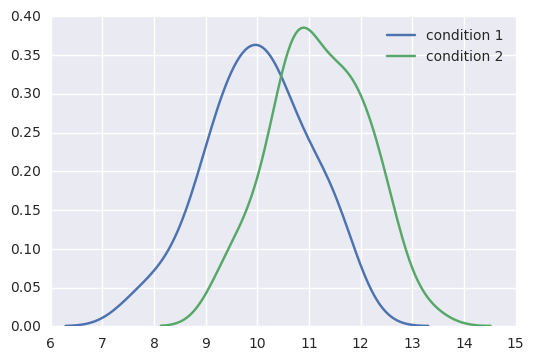

In [3]:
data=make_ttest_data()
Y=data.data.values
X=data.condition.values

f = plt.figure()
sns.distplot(Y[X==0], hist=False, label="condition 1")
sns.distplot(Y[X==1], hist=False, label="condition 2")

Now we want to perform a t-test to ask whether the means of the two conditions are different. Let's try to compute it on our own, using linear algebra.  Remember that the formula for the GLM is:

$Y = X * B + e$

where Y is an N X 1 matrix containing the data that we generated, and X is an N X c "design matrix" that describes the conditions (in this case, a single vector indicating condition 1 or 2).  Using the normal equations, we can estimate B using:

$\hat{B} = (X'X)^{-1}X'Y$

Before we dive into these computations, we need to go over how to do linear algebra in Python. The following borrows liberally from https://www.ibm.com/developerworks/community/blogs/jfp/entry/Elementary_Matrix_Operations_In_Python?lang=en


#### Making arrays/matrices in Python

In [4]:
# to make an array, we give a list to numpy.array
y = numpy.array([1,3,2])
print(y)
print('y shape:',y.shape)

# we can add a dimension with the None operator
z=y[:,None]
print(z)
print('z shape:',z.shape)

# one option to create a matrix is to give a vector and reshape to a matrix
print('A')
A = numpy.array([1,1,2,3,5,8,13,21,34]).reshape(3,3)
print(A)

# another alternative is to pass a list of lists
print('B')
B = numpy.array([[1,1,2],[3,5,8],[13,21,34]])
print(B)

# to transpose a matrix, use the .T operator
print('B.T')
print(B.T)

[1 3 2]
y shape: (3,)
[[1]
 [3]
 [2]]
z shape: (3, 1)
A
[[ 1  1  2]
 [ 3  5  8]
 [13 21 34]]
B
[[ 1  1  2]
 [ 3  5  8]
 [13 21 34]]
B.T
[[ 1  3 13]
 [ 1  5 21]
 [ 2  8 34]]


There are some useful functions to generate specific types of matrices

In [5]:
# create a matrix full of zeros
# note that the shape is passed as a tuple if you want multiple dimensions
a=numpy.zeros((2,4))
print('a')
print(a)

#create a matrix full of ones
b=numpy.ones((2,4))
print('b')
print(b)

# create a matrix full of any other number:
c=b*12
print('c')
print(c)

# create a range of numbers:
d=numpy.arange(10)
print('d')
print(d)

e=numpy.arange(3,5,0.33)
print('e')
print(e)



a
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
b
[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
c
[[ 12.  12.  12.  12.]
 [ 12.  12.  12.  12.]]
d
[0 1 2 3 4 5 6 7 8 9]
e
[ 3.    3.33  3.66  3.99  4.32  4.65  4.98]


Now let's look at some basic arithmetic operations

In [6]:
print('a+5')
print(a+5)

print('c/2')
print(c/2)

print('a+b+c')
print(a+b+c)

print('a*b*c')
print(a*b*c)

print('b/c')
print(b/c)



a+5
[[ 5.  5.  5.  5.]
 [ 5.  5.  5.  5.]]
c/2
[[ 6.  6.  6.  6.]
 [ 6.  6.  6.  6.]]
a+b+c
[[ 13.  13.  13.  13.]
 [ 13.  13.  13.  13.]]
a*b*c
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
b/c
[[ 0.08333333  0.08333333  0.08333333  0.08333333]
 [ 0.08333333  0.08333333  0.08333333  0.08333333]]


#### Matrix multiplication

Matrix multiplication is performed on numpy arrays using the .dot() operator.  

In [7]:
x=numpy.array([[1,2],[3,4]])
y=numpy.array([[1,0],[0,2]])
print('x')
print(x)
print('y')
print(y)

print('scalar product of x and y: x*y')
print(x*y)
print('matrix product of x and y: x.dot(y)')
print(x.dot(y))
print('or use numpy.matrix')
print(numpy.matrix(x)*numpy.matrix(y))

x
[[1 2]
 [3 4]]
y
[[1 0]
 [0 2]]
scalar product of x and y: x*y
[[1 0]
 [0 8]]
matrix product of x and y: x.dot(y)
[[1 4]
 [3 8]]
or use numpy.matrix
[[1 4]
 [3 8]]


__Exercise__: We know that the variance of a matrix X is computed as $mean((X-mean(X))*(X-mean(X))')$.  Fill in the appropriate code in the function below so that it returns a value that equals the value obtained from the numpy.var() command.

In [56]:
def variance(Y):
    # insert code here to estimate variance using matrix multiplication

    return var

# use allclose rather than == to deal with numerical errors
assert numpy.allclose(numpy.var(Y),variance(Y))

NameError: name 'var' is not defined

__Exercise__: Write a function to compute the correlation coefficient using matrix algebra. The equation to compute the correlation using matrix algebra is:

$r = \frac{X\cdot Y}{\sqrt{(X\cdot X)*(Y\cdot Y)}}$

assuming that X and Y have zero mean, so you need to remove the mean before computing this.

In [8]:
def corrcoef(x,y):
    assert len(x)==len(y)
    # add code here to compute correlation

    return r

print('My result:',corrcoef(X,Y))
print('Numpy result:',numpy.corrcoef(X,Y))
assert numpy.allclose(numpy.corrcoef(X,Y)[0,1],corrcoef(X,Y))

NameError: name 'r' is not defined

#### Matrix inversion

We also need to know how to compute the inverse of a matrix, which we do using numpy.linalg.inv().

__Exercise:__ In the cell below, create a matrix containing the following numbers:

[1,0]
[0,2]

and print out the original matrix along with the inverted matrix.

In [58]:
# Exercise code here

Now that we know how to perform the necessary matrix operations, let's do our t-test on the data generated above.  We first have to fix a problem: we need both X and Y to be matrices for our computation to work, but right now they are 1-dimensional vectors rather than two-dimensional matrices.  We can fix this using numpy - let's go ahead and create a function to compute the ordinary least squares estimates, that includes code to reformat the data into matrices.  We also include an option to add an intercept (i.e. a column of ones) to the model if it doesn't already exist.  

In [9]:
def ols_estimate(X,Y,add_intercept=True,verbose=False,
                ddof=1,use_two_sided=True):
    """
    function to estimate parameters for a general linear model
    """
    
    # first we need to set up the matrices in the proper shape
    # Y should be N X 1
    # X should be X X c
    
    if verbose:
        print('original Y shape:',Y.shape)
    Y=Y.reshape((len(Y),1))
    if verbose:
        print('new Y shape:',Y.shape)
    if verbose:
        print('original X shape:',X.shape)
    if len(X.shape)==1:
        X=X.reshape((len(X),1))
    Xnames=['X%d'%int(i+1) for i in range(X.shape[1])]
    if verbose:
        print('new X shape:',X.shape)
        
    # add an intercept to the model if specified
    if add_intercept:
        X=sm.add_constant(X)
        Xnames=Xnames.append('Intercept')

    # make sure that the design matrix is full rank
    assert numpy.linalg.matrix_rank(X)==X.shape[1]
    
    # estimate the parameters using the normal equations
    b_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    if verbose:
        print('b_hat=',b_hat)
        
    # compute residuals and their variance
    resid=Y-X.dot(b_hat)
    sigma2=resid.T.dot(resid)/(X.shape[0] - X.shape[1])  # variance of the residuals
    
    # now compute the t statistic and p values for for each variable in X
    t=numpy.zeros(X.shape[1])
    p=numpy.zeros(X.shape[1])

    for i in range(X.shape[1]):
        c=numpy.zeros(X.shape[1])
        c[i]=1
        t[i]=c.dot(b_hat)/numpy.sqrt(c.dot(numpy.linalg.inv(X.T.dot(X))).dot(c.T)*sigma2)
        if t[i]<0:
            p[i]=scipy.stats.distributions.t.cdf(t[i],len(Y)-1)
        else:
            p[i]=1-scipy.stats.distributions.t.cdf(t[i],len(Y)-1)
        if use_two_sided:
            p[i]=p[i]*2
    if verbose:
        print('t=',t)
        

    df=pandas.DataFrame({'bhat':b_hat.ravel(),'t':t.ravel(),'p':p.ravel()},index=Xnames)
    return df


Now let's estimate the model parameters using our function.

In [10]:
e=ols_estimate(X,Y)
display(e)

,bhat,p,t
0,9.997307,0.000000e+00,74.610001
1,1.181156,1.123781e-08,6.233131


Let's compute the same test using a couple of other canned procedures.  First, we use the t-test procedure within the scipy package.  

In [11]:
t,p=scipy.stats.ttest_ind(Y[X==1],Y[X==0])
print('t/p computed by scipy:',t,p)

assert numpy.allclose(t,e.t.values[1])

t/p computed by scipy: 6.23313124939 1.15364506566e-08


We can also compute it via the general linear model, using the ordinary least squares (OLS) method from statsmodels.

In [12]:
X=sm.add_constant(X)
ols_result=sm.OLS(Y,X).fit()
print(ols_result.summary())

# make sure our result is close to the one from statsmodels
for i in range(len(e.t.values)):
    assert numpy.allclose(e.t.values[i],ols_result.tvalues[i])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     38.85
Date:                Mon, 17 Oct 2016   Prob (F-statistic):           1.15e-08
Time:                        02:11:43   Log-Likelihood:                -135.49
No. Observations:                 100   AIC:                             275.0
Df Residuals:                      98   BIC:                             280.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          9.9973      0.134     74.610      0.0

__Exercise:__ Confirm that the dot product between the residuals from OLS and the X variable is zero.

In [13]:
residual=Y - X.dot(e.bhat.values)

## insert code here


### Multiple regression

Let's now look at how we can fit a more complex model using the GLM. Let's make some data based on two regressors plus noise.  We will make one of the regressors smooth across observations, for reasons that will become clearer later.

In [16]:
def mkar1noise(tslen,coef,noisesd):
    """
    function to return AR(1) autocorrelated noise
    """
    varcorrect = numpy.sqrt(1-coef**2)
    noise=numpy.random.randn(tslen)*noisesd
    for i in range(1,tslen):
        noise[i]=noise[i]*varcorrect+noise[i-1]*coef
    return noise


def make_regression_data(nobs=100,regsmooth=[1],
                         regsmoothcoef=0.8,
                         beta=[0.1,0.5,10],noisesd=1.,
                        noisecorr=0):
    """
    function to generate regression data 
    with option to add autocorrelated noise
    beta reflects two conditions plus intercept
    """
    regs=numpy.random.randn(nobs,len(beta)-1)
    regvarcorrect = numpy.sqrt(1-regsmoothcoef**2)
    for r in regsmooth:
         for i in range(1,nobs):
            regs[i,r]=regs[i,r]*regvarcorrect+regs[i-1,r]*regsmoothcoef

    regs=numpy.hstack((regs,numpy.ones((regs.shape[0],1))))
    data=regs.dot(numpy.array(beta))
    if noisecorr==0:
        noise=numpy.random.randn(len(data))*noisesd
    else:
        noise=mkar1noise(len(data),noisecorr,noisesd)

    return data+noise,regs

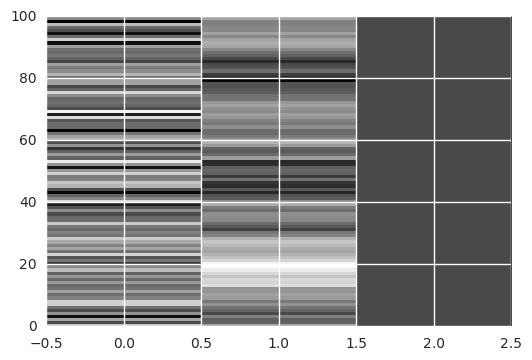

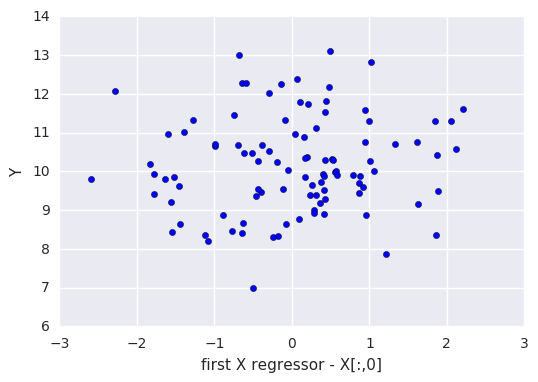

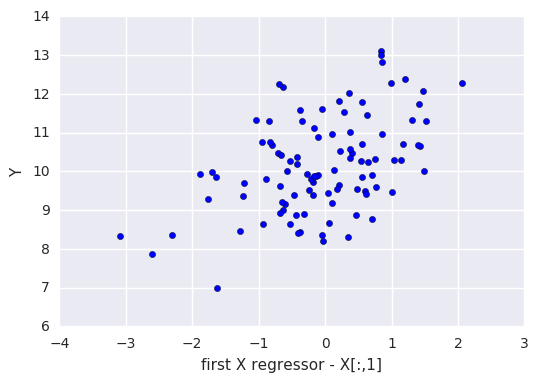

In [17]:
Y,X=make_regression_data()

#X=X-numpy.mean(X,0)
plt.imshow(X,interpolation='nearest')
plt.axis('auto')
plt.ylim([0,100])

plt.figure()
plt.scatter(X[:,0],Y)
plt.xlabel('first X regressor - X[:,0]')
plt.ylabel('Y')
plt.figure()
plt.scatter(X[:,1],Y)
plt.xlabel('first X regressor - X[:,1]')
plt.ylabel('Y')



In [18]:
e=ols_estimate(X,Y)
display(e)

,bhat,p,t
0,0.128604,2.310842e-01,1.204978
1,0.628573,3.849101e-07,5.440474
2,10.199636,0.000000e+00,93.698497


Let's run the same analysis using a canned function from the statsmodels package to compare the results.  Note that statsmodels automatically adds an intercept, so we don't pass that column from the design matrix.

In [19]:
ols_result=sm.OLS(Y,X).fit()
print(ols_result.summary())

for i in range(len(e.t.values)):
    assert numpy.allclose(e.t.values[i],ols_result.tvalues[i])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     15.36
Date:                Mon, 17 Oct 2016   Prob (F-statistic):           1.61e-06
Time:                        02:13:06   Log-Likelihood:                -148.68
No. Observations:                 100   AIC:                             303.4
Df Residuals:                      97   BIC:                             311.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1286      0.107      1.205      0.2

### Beyond ordinary least squares

In the foregoing, we used ordinary least squares estimation, which is the best linear unbiased estimator in the case of uncorrelated and homoscedastic (equal variance) errors (according to the Gauss-Markov theorem).  However, there are common situations where these assumptions fail, in which case we need to use more sophisticated models.  The case that is most relevant to fMRI is when there are correlated errors, which we will explore below.

First, let's simulate performance using OLS when the assumptions are upheld - the Type I error rate should be about 0.05.

In [20]:
nruns=1000
pval=numpy.zeros((nruns,3))
bhat=numpy.zeros((nruns,3))

for i in range(nruns):
    Y,X=make_regression_data(beta=[0,0,0])
    e=ols_estimate(X,Y)
    pval[i,:]=e.p.values
    bhat[i,:]=e.bhat.values

df=pandas.DataFrame({'Type 1 error':[numpy.mean(pval[:,i]<0.05) for i in range(3)],
                     'Variance of bhat':[numpy.std(bhat[:,i]) for i in range(3)]},
                    index=['X1','X2','intercept'])
display(df)


,Type 1 error,Variance of bhat
X1,0.041,0.102526
X2,0.059,0.113243
intercept,0.052,0.106090


Now let's introduce some correlated noise, using the function created above which smooths the noise across observations using a first-order autoregressive (AR(1)) model.  We do this for a range of levels of autocorrelation; because we have set the true beta values to zero, and the resulting proportion of significant results tells us the Type 1 error. We also assess the variance of the estimates.

In [21]:
nruns=1000
ncvals=numpy.arange(0.0,0.9,0.1)

pval=numpy.zeros((nruns,3,len(ncvals)))
bhat=numpy.zeros((nruns,3,len(ncvals)))

for nc in range(len(ncvals)):
    for i in range(nruns):
        Y,X=make_regression_data(beta=[0,0,0],noisecorr=ncvals[nc])
        e=ols_estimate(X,Y,add_intercept=False)
        pval[i,:,nc]=e.p.values
        bhat[i,:,nc]=e.bhat.values


(0, 1)

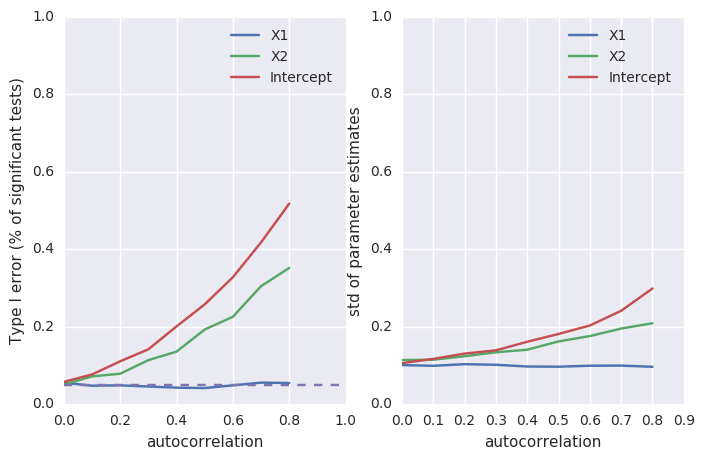

In [22]:
pval_exc=pval<0.05
meanpval=numpy.mean(pval_exc,0)

f=plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(ncvals,meanpval.T)
plt.plot([0,1],[0.05,0.05],'--')
plt.xlabel('autocorrelation')
plt.ylabel('Type I error (% of significant tests)')
plt.legend(['X1','X2','Intercept'])
plt.ylim([0,1])

plt.subplot(1,2,2)
bhvar=numpy.std(bhat,0)
plt.plot(ncvals,bhvar.T)

plt.xlabel('autocorrelation')
plt.ylabel('std of parameter estimates')
plt.legend(['X1','X2','Intercept'])
plt.ylim([0,1])



__Exercise__: What do you see?  Why do the effects of correlation in the data differ between regressors?

### Generalized least squares

In cases where the data do not adhere to the assumptions of OLS, we can use generalized least squares to obtain BLUE estimates.  This requires that we have a model of the autocorrelation structure.  Let's use a Toeplitz matrix, allows us to create an AR(1) covariance matrix.

The Toeplitz matrix has this form (in this case for a dataset with 4 observations):



In [23]:
print(toeplitz(range(4)))

[[0 1 2 3]
 [1 0 1 2]
 [2 1 0 1]
 [3 2 1 0]]


The AR1 covariance has this form:

$V = \sigma^2 \begin{bmatrix}1 & \rho & \rho^2 & \rho^3\\ 
\rho & 1 & \rho & \rho^2\\
\rho^2 & \rho & 1 & \rho \\
\rho^3 & \rho^2 & \rho & 1 \\\end{bmatrix}$

where $\rho$ is the first-order autocorrelation and $\sigma^2$ is the variance.  Note that we still assume that the variances are homogenous across datapoints.  Thus, to generate such a matrix we simply exponentiate $\rho$ by the Toeplitz matrix (which is acheived using the $**$ operator) in Python.

In [24]:
rho=0.3
print(rho**toeplitz(range(4)))


[[ 1.     0.3    0.09   0.027]
 [ 0.3    1.     0.3    0.09 ]
 [ 0.09   0.3    1.     0.3  ]
 [ 0.027  0.09   0.3    1.   ]]


Now let's build a version of our estimator that uses GLS rather than OLS.  We do this using an interative approach.  We first run OLS to estimate the model and obtain the residuals, and then we estimate the autocorrelation structure from the residuals.  Then we estimate the model using GLS with the autocorrelation structure estimated above. The GLS estimator is:

$\hat{B} = (X'V^{-1}X)^{-1}X'V^{-1}Y$

where $V$ is the covariance matrix (which in OLS we assumed was simply $\sigma^2I$).  This is akin to "whitening" the data by removing the covariance structure.

In [47]:
def gls_estimate(X,Y,add_intercept=True,verbose=False,
                ddof=1,use_two_sided=True):
    """
    estimate generalized least squares
    using a Toeplitz matrix to generate AR(1) covariance
    """
    # first we need to set up the matrices in the proper shape
    # Y should be N X 1
    # X should be X X c
    
    if verbose:
        print('original Y shape:',Y.shape)
    Y=Y.reshape((len(Y),1))
    if verbose:
        print('new Y shape:',Y.shape)
    if verbose:
        print('original X shape:',X.shape)
    if len(X.shape)==1:
        X=X.reshape((len(X),1))
    Xnames=['X%d'%int(i+1) for i in range(X.shape[1])]
    if verbose:
        print('new X shape:',X.shape)
        
    # add an intercept to the model if specified
    if add_intercept:
         X=sm.add_constant(X)
    
    # make sure that the design matrix is full rank
    assert numpy.linalg.matrix_rank(X)==X.shape[1]            

    # first fit OLS to get residuals for AC estimation
    e=ols_estimate(X,Y)
    resid=Y - X.dot(e.bhat.values[:,numpy.newaxis])
    ar1_coef=statsmodels.tsa.stattools.acf(resid)[1] # get the first-order autocorrelation estimate
    
    # compute the inverse covariance matrix 
    order=toeplitz(range(len(Y)))
    sigma=ar1_coef**order
    Vinv=numpy.linalg.inv(sigma)

    # re-estimate the model using GLS
    b_hat=numpy.linalg.inv(X.T.dot(Vinv).dot(X)).dot(X.T.dot(Vinv).dot(Y))

    if verbose:
        print('b_hat=',b_hat)
    resid=Y-X.dot(b_hat)
    sigma2=resid.T.dot(resid)/(X.shape[0] - X.shape[1])  # variance of the residuals
    
    # now compute the t statistic and p values for for each variable in X
    t=numpy.zeros(X.shape[1])
    p=numpy.zeros(X.shape[1])

    for i in range(X.shape[1]):
        c=numpy.zeros(X.shape[1])
        c[i]=1
        t[i]=c.dot(b_hat)/numpy.sqrt(c.dot(numpy.linalg.inv(X.T.dot(Vinv).dot(X))).dot(c.T)*sigma2)

        if t[i]<0:
            p[i]=scipy.stats.distributions.t.cdf(t[i],len(Y)-1)
        else:
            p[i]=1-scipy.stats.distributions.t.cdf(t[i],len(Y)-1)
        if use_two_sided:
            p[i]=p[i]*2
    if verbose:
        print('t=',t)
        

    df=pandas.DataFrame({'bhat':b_hat.ravel(),'t':t.ravel(),'p':p.ravel()},index=Xnames)
    return df



In [48]:
order=toeplitz(range(len(Y)))
sigma=0.5**order

Y,X=make_regression_data(beta=[1,0.1,10],noisecorr=0.5)

e=gls_estimate(X,Y)
display(e)

gls_result=sm.GLS(Y,X,sigma=sigma).fit()

gls_result.summary()

,bhat,p,t
X1,0.944793,0.00000,12.645480
X2,0.387659,0.00025,3.800491
X3,9.840160,0.00000,76.738843


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.643
Model:                            GLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     87.37
Date:                Mon, 17 Oct 2016   Prob (F-statistic):           2.01e-22
Time:                        02:20:40   Log-Likelihood:                -122.13
No. Observations:                 100   AIC:                             250.3
Df Residuals:                      97   BIC:                             258.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.9341      0.072     13.038      0.000         0.792     1.076
x2             0.3973      0.117      3.389      0.001         0.165     0.630
const          9.8294      0.165     59.654      0.000         9.502    10.156
==============================================================================
Omnibus:                        1.028   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                0.965
Skew:                          -0.235   Prob(JB):                        0.617
Kurtosis:                       2.898   Cond. No.                         2.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What do you see in this comparison?

Now let's simulate datasets under the null and estimate the model, across different levels of autocorrelation, as we did above. Because the estimation is a bit more complex this will take a couple of minutes.

In [49]:
nruns=1000
ncvals=numpy.arange(0.0,0.9,0.1)

pval=numpy.zeros((nruns,2,len(ncvals)))
bhat=numpy.zeros((nruns,2,len(ncvals)))

for nc in range(len(ncvals)):
    for i in range(nruns):
        Y,X=make_regression_data(beta=[0,0,0],noisecorr=ncvals[nc])

        e=gls_estimate(X,Y)

        pval[i,:,nc]=e.p.values[:2]
        bhat[i,:,nc]=e.bhat.values[:2]



(0, 1)

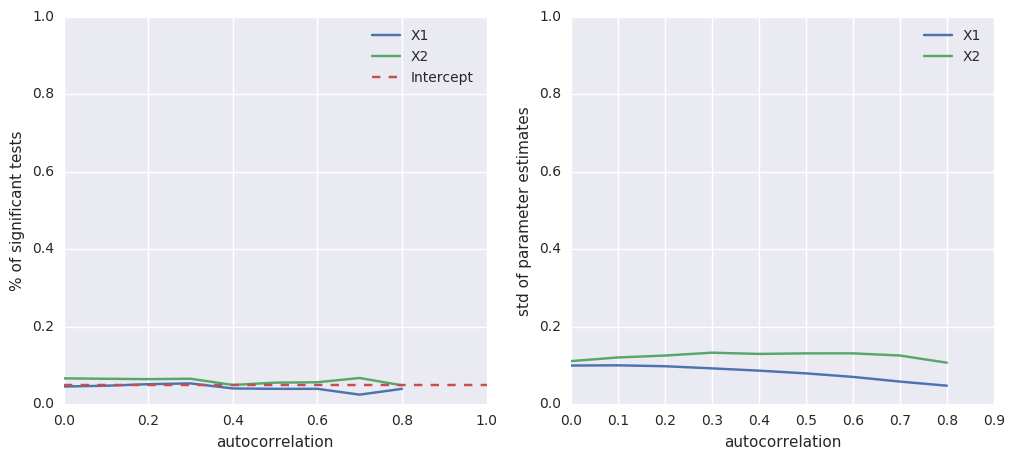

In [50]:
pval_exc=pval<0.05
meanpval=numpy.mean(pval_exc,0)

f=plt.figure(figsize=(12,5))
f=plt.subplot(1,2,1)
plt.plot(ncvals,meanpval.T)
plt.plot([0,1],[0.05,0.05],'--')
plt.xlabel('autocorrelation')
plt.ylabel('% of significant tests')
plt.legend(['X1','X2','Intercept'])
plt.ylim([0,1])
bhvar=numpy.std(bhat,0)
f=plt.subplot(1,2,2)
plt.plot(ncvals,bhvar.T)

plt.xlabel('autocorrelation')
plt.ylabel('std of parameter estimates')
plt.legend(['X1','X2','Intercept'])
plt.ylim([0,1])
